In [1]:
import math
import sqlite3
from html import escape
from itertools import groupby
from operator import itemgetter
from pathlib import Path

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.core.display import HTML
from docutils.core import publish_parts

%matplotlib inline
plt.style.use('ggplot')

In [2]:
conn = sqlite3.connect('compression.db')

In [3]:
def render_rst(rst):
    """
    Given reStructuredText *rst*, return the rendered HTML
    content, excluding the surrounding outer-most ``<body>``
    elements.
    """
    return HTML(publish_parts(rst, writer_name='html')['html_body'])

In [4]:
render_rst(Path('README.rst').read_text())

Name,Type,Description
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
Name,Type,Description
machine,TEXT,The label provided on by --machine on the command line
arch,TEXT,The dpkg architecture of the machine
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
succeeded,INTEGER,"1 if the compression run succeeded, and 0 if it failed"


## Analysis Functions

Some convenience functions for rendering the output of SQL queries as tables
and graphs; these are not important to the analysis -- feel free to skip down
to the "Analysis Results" heading.

In [5]:
def render_table(cur):
    """
    Given *cur*, a cursor containing a database result set, return a string
    containing the result set rendered as an HTML ``<table>`` element.
    """
    columns = [r[0] for r in cur.description]
    rows = list(cur)
    cur.close()
    headers = "".join(
        f"<th>{escape(str(header))}</th>"
        for header in columns
    )
    data = "\n".join(
        f"<tr>{html_row}</tr>"
        for row in rows
        for html_row in ("".join(
            f"<td>{escape(str(cell))}</td>"
            for cell in row
        ),)
    )
    return HTML(f"""
<table>
<thead><tr>{headers}</tr></thead>
<tbody>{data}</tbody>
</table>""")

In [6]:
def transpose(seq):
    return list(zip(*seq))

In [7]:
def render_xy(cur):
    """
    Given *cur*, a cursor containing a database result set, plot the results
    on an X-Y scatter graph. The cursor is expected to contain 3 columns:
    
    * The first column must be the "series" column, and must be the first
      column by which the result set is ordered. It can be any data-type but
      is typically a string indicating the series of data that the row belongs
      to. The name of this column is ignored, but the content will be used in
      the key of the graph.
      
    * The second column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The third column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
    """
    style = {'marker': 'o', 'linestyle': 'none'}
    cols = [c[0] for c in cur.description]
    if len(cols) != 3:
        raise ValueError('query must return 3 columns')
    ax = plt.axes()
    for series, rows in groupby(cur, key=itemgetter(0)):
        data = transpose((row[1], row[2]) for row in rows)
        ax.plot(data[0], data[1], label=series, **style)
    ax.set_xlabel(cols[1])
    ax.set_ylabel(cols[2])
    ax.legend()

In [8]:
def render_multi_xy(cur):
    """
    Given *cur*, a cursor containing a database result set, plot the results on
    multiple X-Y scatter graphs within a figure. Each plot shares its X and
    Y scales making the graphs comparable. The cursor must contain 4 columns:
    
    * The first is the graph "title" column. The result set must use this as
      the primary sorting key. Each unique value in this column will produce a
      separate output graph titled with that value. The column name is ignored.
      
    * The second is the "series" column. The result set must use this as the
      secondary sorting key. Each unique value in this column will form a
      separate series of data in the containing graph. The column name is
      ignored.
      
    * The third column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The fourth column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
    """
    style = {'marker': 'o', 'linestyle': 'none'}
    cols = [c[0] for c in cur.description]
    if len(cols) != 4:
        raise ValueError('query must return 4 columns')
    graphs = {}
    for title, rows in groupby(cur, key=itemgetter(0)):
        graphs[title] = [(row[1], row[2], row[3]) for row in rows]
    rows = len(graphs) // 2 + len(graphs) % 2
    fig, axs = plt.subplots(
        rows, 2, figsize=(10, rows * 5),
        sharex=True, sharey=True)
    for ax, title in zip(axs.flat, graphs):        
        graph = graphs[title]
        for series, rows in groupby(graph, key=itemgetter(0)):
            data = transpose((row[1], row[2]) for row in rows)
            ax.plot(data[0], data[1], label=series, **style)
        ax.set_xlabel(cols[2])
        ax.set_ylabel(cols[3])
        ax.legend()
        ax.set_title(title)
        ax.label_outer()
    if len(graphs) % 2:
        axs.flat[-1].set(visible=False)

In [9]:
def render_xyz(cur):
    """
    Given *cur*, a cursor containing a database result set, plot the results on
    three X-Y scatter graphs. The cursor is expected to contain 4 columns:
    
    * The first is the "series" column. The result set must use this as the
      primary sorting key. Each unique value in this column will form a
      separate series of data in the containing graph. The column name is
      ignored.
      
    * The second column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The third column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
      
    * The fourth column must be the "Z" column, and must be numeric values for
      the Z-axis of the graph. The column name will be used as the Z-axis
      title.
      
    The "X" and "Y" columns will be plotted on the top-left "common" graph. The
    "X" and "Z" columns will be plotted below the common graph, and the "Y" and
    "Z" columns will be plotted to the right of the common graph.
    """
    style = {'marker': 'o', 'linestyle': 'none'}
    cols = [c[0] for c in cur.description]
    if len(cols) != 4:
        raise ValueError('query must return 4 columns')
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    cur = list(cur)
    indexes = {'x': 1, 'y': 2, 'z': 3}
    for ax, ax_cols in zip(axs.flat, ('xy', 'zy', 'xz')):
        getter = itemgetter(indexes[ax_cols[0]], indexes[ax_cols[1]])
        for series, rows in groupby(cur, key=itemgetter(0)):
            data = transpose(getter(row) for row in rows)
            ax.plot(data[0], data[1], label=series, **style)
        ax.legend()
        ax.set_xlabel(cols[indexes[ax_cols[0]]])
        ax.set_ylabel(cols[indexes[ax_cols[1]]])
    axs[1, 1].set(visible=False)

## Analysis Results

### Combinations tested

A list of all the machines (and architectures) tested:

In [10]:
render_table(conn.execute("""
SELECT DISTINCT
    machine AS "Machine",
    arch AS "Architecture"
FROM results
"""))

Machine,Architecture
AMD Ryzen 32GB,amd64
Pi 4 8GB,arm64
Pi 4 8GB,armhf
Pi Zero 2 512MB,arm64
Pi Zero 2 512MB,armhf


A list of all the compressors and options tested:

In [11]:
render_table(conn.execute("""
SELECT
    compressor AS "Compressor",
    options AS "Options",
    GROUP_CONCAT(level) AS "Levels"
FROM tests
GROUP BY compressor, options
ORDER BY compressor, options
"""))

Compressor,Options,Levels
bzip2,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
bzip2,-s,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
gzip,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
lz4,,"-1,-10,-11,-12,-2,-3,-4,-5,-6,-7,-8,-9"
lzip,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,-e,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
zstd,,"-1,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-2,-3,-4,-5,-6,-7,-8,-9"
zstd,-T0,"-1,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-2,-3,-4,-5,-6,-7,-8,-9"


Notes:
* The `-e` option for `xz` enables "extreme" (!) compression
* The `-s` option for `bzip2` reduces memory usage
* The `-T0` option for `zstd` enables multi-threaded operation

### Dangerous combinations

Show all compressor+option combinations that failed to produce a result

In [12]:
render_table(conn.execute("""
SELECT
    machine AS "Machine",
    arch AS "Architecture",
    compressor ||
    CASE WHEN options = '' THEN '' ELSE ' ' || options END ||
    CASE WHEN level = '' THEN '' ELSE ' ' || level END AS "Command"
FROM results
WHERE succeeded = 0
"""))

Machine,Architecture,Command
Pi Zero 2 512MB,arm64,xz -7
Pi Zero 2 512MB,arm64,xz -8
Pi Zero 2 512MB,arm64,xz -9
Pi Zero 2 512MB,arm64,xz -e -7
Pi Zero 2 512MB,arm64,xz -e -8
Pi Zero 2 512MB,arm64,xz -e -9
Pi Zero 2 512MB,arm64,zstd -16
Pi Zero 2 512MB,arm64,zstd -17
Pi Zero 2 512MB,arm64,zstd -18
Pi Zero 2 512MB,arm64,zstd -19


From the table above we can see that only the Pi Zero 2 has an issue, and that
only the more aggressive options of ``xz`` and ``zstd`` tend to cause a direct
failure. However, it's worth bearing in mind that these tests were run on
otherwise idle and unloaded systems. We should strive to be as minimal as
possible in both memory and time usage because:

* The more memory we use, the more chance of pushing other services into OOM
  failure. For example, on the Pi Zero 2 (and 3A+) with the arm64 architecture,
  the typical amount of RAM available at runtime with all "default" services
  loaded is only around 200MB. If our compressor takes 50MB of RAM, and a daemon
  is running that takes 100MB of RAM we're at serious risk of pushing the daemon
  into the waiting arms of the OOM killer.

* The more time we use, the more we risk being terminated prematurely. Consider
  that `unattended-upgrades` runs by default and that a kernel upgrade could
  well be running at shutdown time. If our compressor takes 4 minutes to run
  we're at serious risk of the user just pulling the plug (no one waits 4
  minutes for shutdown!).

## Useful combinations

From the above we can rule out certain compressor options (`zstd` above `-10`,
`xz` above `-6`, etc). However, we should have a general overview of how these
compressors fare against each other to see whether one is obviously "better"
than the others, and whether any are sufficiently inferior that we can discard
them immediately.

The following graphs show three data-points, time taken to compress, memory used
to compress, and compression size achieved (in %) all plotted against each other
for a given machine and architecture.
Firstly, a break-down by machine (and architecture); select one from the list to
see all compressor runs on that platform:

In [13]:
machines_archs = list(
    conn.execute("SELECT DISTINCT machine, arch FROM results"))

In [14]:
@widgets.interact(value=widgets.Dropdown(
    options=[
        (f'{machine} ({arch})', (machine, arch))
        for machine, arch in machines_archs
    ],
    value=('AMD Ryzen 32GB', 'amd64'),
    description='Machine'
))
def compare_compressors(value):
    machine, arch = value
    query = """
    SELECT
        compressor,
        comp_duration AS "Elapsed (s)",
        comp_max_mem / 1048576.0 AS "Max. resident size (MB)",
        100.0 * output_size / input_size AS "Compressed size (%)"
    FROM results
    WHERE succeeded = 1
    AND machine = ?
    AND arch = ?
    ORDER BY compressor
    """
    render_xyz(conn.execute(query, (machine, arch)))
    plt.show()

interactive(children=(Dropdown(description='Machine', options=(('AMD Ryzen 32GB (amd64)', ('AMD Ryzen 32GB', '…

Some rough observations from playing with the graphs above:

* `bzip2` has relatively poor time complexity compared to other algorithms; its
  clusters are consistently "right" of the other compressors under test on bottom
  graph indicating that, for the compression achieved, it's taking longer than
  others

* `zstd` has relatively poor memory complexity compared to other algorithms; its
  clusters are consistently "right" of the other compressors in the right-hand
  graph indicating that, for the memory used, it's achieved less compression
  compared to others

* `xz` and `lzip` (both LZMA based compressors) clearly produce the
  best overall compression ratio, but have by *far* the worst time complexity
  (they tail far off to the right on the Elapsed axis), and also poor memory
  complexity at least at their higher levels

* In contrast, `lz4` and the venerable `gzip` both have the worst compression
  ratios but excellent time and memory complexity, though `gzip` appears to be
  consistently better (perhaps `lz4` wins on decompression?)

Next, a look at each compressor (and its options) compared by machine, bearing in
mind that each machine is compressing *its* particular initramfs. Whilst these are
of roughly similar sizes, they obviously aren't identical and will compress
differently.

This is mostly useful for spotting patterns particular to a compressor (or its
options), for example the curves of memory usage in `xz` versus the flat memory
usage of `gzip`:

In [15]:
compressor_options = list(
    conn.execute("SELECT compressor, options FROM options"))

In [16]:
@widgets.interact(value=widgets.Dropdown(
    options=[
        (f'{compressor} {options}', (compressor, options))
        for compressor, options in compressor_options
    ],
    value=('bzip2', ''),
    description='Compressor'
))
def compare_compressors(value):
    compressor, options = value
    query = """
    SELECT
        machine || ' (' || arch || ')',      
        comp_duration AS "Elapsed (s)",
        comp_max_mem / 1048576.0 AS "Max. resident size (MB)",
        100.0 * output_size / input_size AS "Compressed size (%)"
    FROM results
    WHERE succeeded = 1
    AND compressor = ?
    AND options = ?
    ORDER BY 1
    """
    render_xyz(conn.execute(query, (compressor, options))),
    plt.show()

interactive(children=(Dropdown(description='Compressor', options=(('bzip2 ', ('bzip2', '')), ('bzip2 -s', ('bz…

Rough observations from these graphs:

* `lz4` and `gzip` appear to be constant memory algorithms (see the scale of
  the Y-axis on the resident size graphs for these compressors; the variation
  is on the scale of kilobytes)

* There appears to be a significant difference in compression ratio between
  (presumably?) level `-1` of `lz4` and the higher levels

* `xz`, `lzip`, and `zstd` (in particular with the `-T0` multi-threaded option)
  all use terrific amounts of memory at their higher levels. It is particularly
  telling that the Pi Zero 2 results cease above 200MB of usage as everything
  trying to use more simply failed

* `zstd` displays considerable compression gains for little loss in speed, up
  to somewhere in the middle of its range then displays a curious "knee" in
  the bottom graph unlike any other compressor. Performance rapidly trails off
  after this suggesting the lower levels are worth looking at, but the higher
  ones should probably be avoided. The effect is less pronounced with the
  multi-threading `-T0` option, but the difference in memory usage with that
  option suggests it's likely not viable for our use-case

## Narrowing it down

Let's consider the apparently "best" compressors which, from playing with the
graphs above, would appear to be `bzip2`, `zstd`, `xz`, and `lzip` purely
considering their compression ratios (`gzip` and `lz4` are consistently outside
the range of ratios produced by these). Ignoring the actual ratio produced
initially, let's look at their time and space usage, limiting ourselves to runs
that took less than 60s (anything longer than 30s is probably not that useful
to our scenario) and runs that used less than 100MB of resident memory (again,
anything that uses more than 50MB is dangerous on a Pi Zero 2):

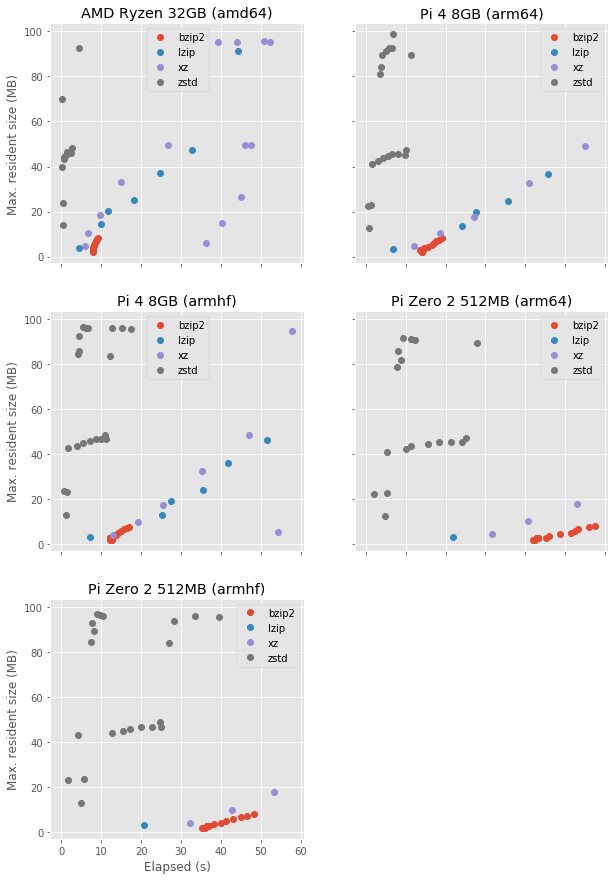

In [17]:
render_multi_xy(conn.execute("""
SELECT
    machine || ' (' || arch || ')' AS title,
    compressor AS series,
    comp_duration AS "Elapsed (s)",
    comp_max_mem / 1048576.0 AS "Max. resident size (MB)"
FROM results
WHERE succeeded = 1
AND comp_duration < 60
AND comp_max_mem < (100 * 1048576)
AND compressor IN ('bzip2', 'zstd', 'xz', 'lzip')
ORDER BY title, series
"""))

On the Pi Zero 2 at least, the `xz` and `lzip` compressors are sufficiently slow
and/or memory heavy that only a few of their data points show up under such
constraints. We can eliminate them from further consideration on this basis.

The newer `zstd` fares much better, but still has some worrying "high-memory
usage" clusters towards the top of the charts. `bzip2` appears to have decent
memory usage, but its runtimes are consistently slow (no values to the left of
the graphs). Ignoring memory usage for a second, are there *any* cases where
`bzip2` beats `zstd` on compression ratio versus speed?

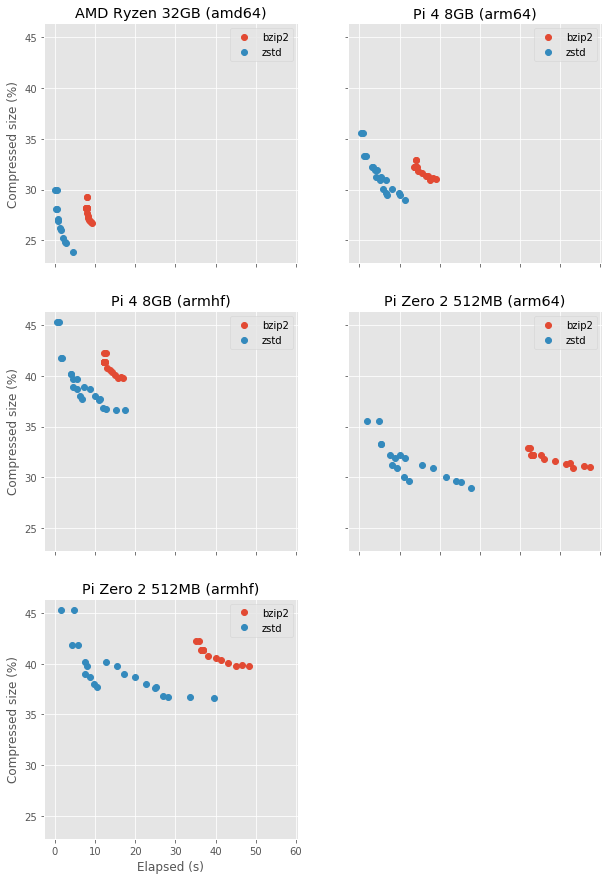

In [18]:
render_multi_xy(conn.execute("""
SELECT
    machine || ' (' || arch || ')' AS title,
    compressor AS series,
    comp_duration AS "Elapsed (s)",
    100.0 * output_size / input_size AS "Compressed size (%)"
FROM results
WHERE succeeded = 1
AND comp_duration < 60
AND comp_max_mem < (100 * 1048576)
AND compressor IN ('bzip2', 'zstd')
ORDER BY title, series
"""))

There are not: it is always possible to produce something with `zstd` that is
smaller than the `bzip2` output, in a shorter time (at least, for our limited
set of inputs).
However, determining a
single level at which this occurs may be non-trivial given the wide range of
behaviour that `zstd` demonstrates. That said, the graphs above also remind us
that, even at `-1` level, `bzip2` is likely too slow on the Pi Zero 2.

Returning to our concern about the memory usasge of `zstd`, it is worth bearing
in mind that since the Impish release of Ubuntu (21.10), the
Ubuntu Pi kernel has shipped with a cut down list of modules which can be
expanded by installing the `linux-modules-extra-raspi` package. This can boost
the size of the initramfs quite substantially (which was a large part of the
motivation in splitting the modules out in the first place). Would this
affect the memory usage of `zstd`? In other words, is memory usage determined
partly by input size, or solely by compression level?

As it happens, our input sizes are specific to each architecture:

In [19]:
render_table(conn.execute("""
SELECT DISTINCT arch, input_size
FROM results
WHERE succeeded = 1
"""))

arch,input_size
amd64,182272000
arm64,77631488
armhf,58892800


Given this, we can query the memory usage of zstd by compression level and
architecture to take a reasonable guess at its memory usage patterns:

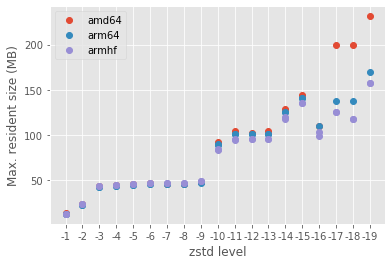

In [20]:
render_xy(conn.execute("""
SELECT
    arch,
    level AS "zstd level",
    comp_max_mem / 1048576.0 AS "Max. resident size (MB)"
FROM results
WHERE succeeded = 1
AND compressor = 'zstd'
AND options = ''
ORDER BY arch, -CAST(level AS INT)
"""))

The spread evident in the later compression levels strongly suggests that `zstd`
is variable according to input size (particularly given that the archs with the
larger inputs consistently use more memory).
Admittedly, the spread is extremely small below level `-10`. Nonetheless, the
levels from `-3` onwards all skirt very close to the 50MB "danger zone" on the
Pi Zero 2. Further, given an algorithm that explicitly varies with input size
there's no strong guarantee that later versions (or option changes) won't push
us slightly over some boundary (like 50MB resident usage).

If we selected a compressor with fixed memory usage (O(1) memory complexity),
this concern is substantially alleviated. From playing with the interactive
charts earlier, we can guess that `lz4` and `gzip` demonstrate such behaviour,
but let's confirm this by querying which compressors (and options) demonstrate
no more than 1MB of difference between their minimum and maximum memory usage
per machine (and arch):

In [21]:
render_table(conn.execute("""
SELECT
    compressor || CASE WHEN options = '' THEN '' ELSE ' ' || options END AS "Command",
    arch AS "Architecture",
    (MAX(comp_max_mem) - MIN(comp_max_mem)) / 1048576.0 AS "Mem Range (MB)"
FROM results
WHERE succeeded = 1
GROUP BY 1, 2
HAVING MAX(comp_max_mem) - MIN(comp_max_mem) <= 1048576
"""))

Command,Architecture,Mem Range (MB)
bzip2 -s,amd64,0.8203125
bzip2 -s,arm64,0.88671875
bzip2 -s,armhf,0.83203125
gzip,amd64,0.14453125
gzip,arm64,0.1171875
gzip,armhf,0.1484375
lz4,amd64,0.48046875
lz4,arm64,0.37109375
lz4,armhf,0.2578125


As suspected, `lz4` and `gzip` are (for our limited range of inputs at least),
effectively constant memory compressors.
Intriguingly, `bzip2` has a `-s` option which, according to the [manpage], is
intended to "reduce memory-usage". In fact, it seems to switch it from an
algorithm which varies (minimally) in memory usage to one that uses a fixed (?)
size buffer. It would be ideal if `zstd` had such a switch (not to mention
`xz` and `lzip`)!

However, we've already eliminated `bzip2` over other performance concerns, and
`zstd` from levels `-3` are so close to our 50MB memory limit that we should
try and seek a reasonable alternatives if we can. `zstd` levels `-1` and `-2`
look good, but their compression ratios may not be competitive against other
combinations. How do these compare to the `lz4` and `gzip` compressors (at any
of their levels)? We'll limit the query to runs that took less than 30 seconds
and less than 50MB of resident memory:

[manpage]: https://manpages.ubuntu.com/manpages/jammy/en/man1/bzip2.1.html

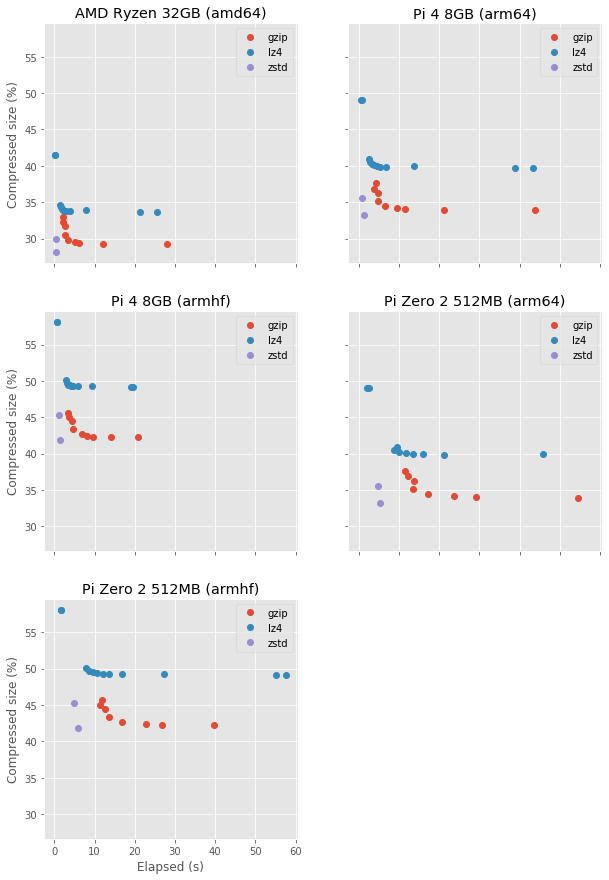

In [22]:
render_multi_xy(conn.execute("""
SELECT
    machine || ' (' || arch || ')' AS title,
    compressor AS series,
    comp_duration AS "Elapsed (s)",
    100.0 * output_size / input_size AS "Compressed size (%)"
FROM results
WHERE succeeded = 1
AND comp_duration < 60
AND comp_max_mem < (100 * 1048576)
AND (
    compressor IN ('gzip', 'lz4')
    OR (
        compressor = 'zstd'
        AND options = ''
        AND level IN ('-1', '-2')
    )
)
ORDER BY title, series
"""))

The `-1` and `-2` levels of `zstd` look extremely good from these graphs,
typically producing slightly better compression than `gzip` in roughly half the
time.
By comparison, `lz4` barely seems competitive and I have to wonder whether the
move from `gzip` to `lz4` in initramfs-tools was worthwhile (perhaps we'll
see some difference when analyzing the decompression performance)?

## Decompression comparisons

So far we've ignored the decompression side of things entirely. We should have
a quick look at the performance of all the compressors to get a quick feel for
things:

In [25]:
@widgets.interact(value=widgets.Dropdown(
    options=[
        (f'{machine} ({arch})', (machine, arch))
        for machine, arch in machines_archs
    ],
    value=('AMD Ryzen 32GB', 'amd64'),
    description='Machine'
))
def compare_compressors(value):
    machine, arch = value
    query = """
    SELECT
        compressor,
        decomp_duration AS "Elapsed (s)",
        decomp_max_mem / 1048576.0 AS "Max. resident size (MB)",
        100.0 * output_size / input_size AS "Compressed size (%)"
    FROM results
    WHERE succeeded = 1
    AND machine = ?
    AND arch = ?
    ORDER BY compressor
    """
    render_xyz(conn.execute(query, (machine, arch)))
    plt.show()

interactive(children=(Dropdown(description='Machine', options=(('AMD Ryzen 32GB (amd64)', ('AMD Ryzen 32GB', '…

The graphs above do show that `xz`, `lzip` and `bzip2` are all significant
outliers in terms of decompression performance: far slower than `lz4`, `gzip`
and `zstd`. The LZMA compressors also use serious amounts of memory for
decompression at their higher levels (bear in mind that at the higher levels,
the Pi Zero 2 failed to run these algorithms and so there's no decompression
data for them either).

Also notable is that `lz4` is definitively quicker than `gzip` at all levels.
Given that the initramfs is presumably read (and thus decompressed) more than
it is written (and compressed), this does make a reasonable case for the use of
`lz4` (at certain levels; the `-9` level currently used by initramfs-tools is
almost certainly not worthwhile in terms of compression performance).

## Limits

Let's try and quantify some of this with the limits we've explored above:

* We're only interested in compressors, options and levels which can
  consistently operate in less than 50MB of memory, and in less than 30s
  of runtime

* We'll define some I/O speeds for reading the initramfs on various
  architectures:

  - 10MB/s on `armhf` and `arm64` as that's a typical SD card speed
  - 250MB/s on `amd64` as that's a reasonable SSD/NVMe speed

* 20 reads of the initramfs (boots) per write (per kernel upgrade essentially)
  This is highly speculative. It could be 1 (never rebooted except on kernel
  upgrades), or effectively infinite (an ephemeral cloud image that only ever
  reads the initramfs on boot, but never upgrades it and so never writes it).

Starting from these assumptions, here's an interactive table which shows
compressors, their options, and a level, limited to those combinations which
successfully run in the defined limits, ordered by their overall "score":
the sum of the compression time, the time to read and decompress the
compressed output a certain number of times (20 by default), summed across
all sampled machines.
Also shown are some of the ranges (duration and compression ratio) achieved
by the specified combination.

The table is limited to 20 rows of output for brevity. You can modify the
limits and reads per write ratio with the sliders to try different limits and
scenarios:

In [24]:
@widgets.interact(
    mem_limit=widgets.IntSlider(
        value=50, min=10, max=200,
        description='Memory limit (MB)',
        readout_format='d'),
    duration_limit=widgets.IntSlider(
        value=30, min=5, max=60,
        description='Duration limit (s)',
        readout_format='d'),
    reads_per_write=widgets.IntSlider(
        value=20, min=1, max=100,
        description='Reads per write',
        readout_format='d'))
def compare_compressors(mem_limit=50, duration_limit=30, reads_per_write=20):
    query = """
WITH all_machines AS (
    SELECT DISTINCT machine, arch
    FROM results
),
valid_compressors AS (
    -- Find only those compressor options and levels
    -- which successfully ran within the limits
    -- for *all* sampled machines and archs
    SELECT compressor, options, level
    FROM results
    WHERE succeeded = 1
    AND comp_max_mem < (? * 1048576)
    AND comp_duration < ?
    GROUP BY compressor, options, level
    HAVING COUNT(*) = (SELECT COUNT(*) FROM all_machines)
)
SELECT
    compressor AS "Compressor",
    options AS "Options",
    level AS "Level",
    ROUND(SUM(
        comp_duration +
        (
            output_size / (
                CASE arch
                    -- Per arch I/O speeds
                    WHEN 'amd64' THEN 250
                    WHEN 'armhf' THEN 10
                    WHEN 'arm64' THEN 10
                    -- Fail (div/0) for undefined archs
                    ELSE 0
                END * 1048576.0
            ) +
            decomp_duration
        ) * ?
    ), 2) AS "Total 'Score'",
    ROUND(MAX(comp_max_mem) / 1048576.0, 2) AS "Max res. size (MB)",
    CAST(MIN(comp_duration) AS VARCHAR) || ' - ' ||
    CAST(MAX(comp_duration) AS VARCHAR) AS "Comp. duration (s)",
    CAST(ROUND(MIN(100.0 * output_size / input_size), 2) AS VARCHAR) || ' - ' ||
    CAST(ROUND(MAX(100.0 * output_size / input_size), 2) AS VARCHAR) AS "Ratio (%)"
FROM results
    JOIN valid_compressors USING (compressor, options, level)
GROUP BY compressor, options, level
ORDER BY 4
LIMIT 20
    """
    return render_table(conn.execute(query, (
        mem_limit, duration_limit, reads_per_write)))

interactive(children=(IntSlider(value=50, description='Memory limit (MB)', max=200, min=10), IntSlider(value=3…

Playing around with the queries above, I conclude the following:

* The duration limit beyond 20s makes little to no difference to the results

* There is largely no point in going beyond `zstd -8` even on huge platforms.
  Even maximizing the memory limits and reads per write, the higher levels
  like `-10` do not approach the top of the table suggesting the compression
  gains made are either negligible or outweighed by increased decompression
  time

* If memory is no object, `zstd -T0` is unassailable. At few reads per write,
  `zstd -T0 -1` wins. At many reads per write, `zstd -T0 -8` wins. However, this
  requires a considerable memory commitment (150MB+)

* With a 50MB memory limit (our original assumption) `zstd -2` is usually best.
  Occasionally `zstd -T0 -1` wins but `-2` has preferable memory usage

* If we tighten our memory constraint down to 30MB, `lz4` at a couple of levels
  becomes competitive with `zstd -2`

* Tighter still, to 20MB, and `lz4` comes to dominate (though `zstd -1` still
  appears in the table at various points)

## Conclusion

`zstd` at the lower levels (`-1` or `-2`) is clearly an excellent choice and
likely "safe" on the smaller platforms. However it is worth bearing in mind that
even a tight limit of 20MB of resident memory still represents nearly 10% of the
*available* memory on the Pi Zero 2 arm64 platform at runtime. Hence, we should
aim to be as conservative as we reasonably can on memory usage.

To that end, given that `lz4` appears to demonstrate more or less constant
memory usage (or is at least considerably less affected by input size than
`zstd`), it is probably the safest choice for the default initramfs compressor.
However, its current configuration in initramfs-tools (using the `-9` level)
should be altered. There is no benefit to using such a high level, while there
are several downsides including excessive runtime and achieving little to no
extra compression. The `-3` or `-4` levels appear to confer the best trade-off
between runtime and compression ratio in a variety of configurations.